In [1]:
from google.colab import files
uploaded = files.upload()

Saving StackOverflow_questions_cleaned_Bis2.csv to StackOverflow_questions_cleaned_Bis2.csv


In [2]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

In [ ]:
# Install package for PEP8 verification
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.5 MB/s eta 0:00:00
Looking in indexes: https://test.pypi.org/simple/


In [3]:
import io
#import pickle
#data = pickle.load(open('./data/StackOverflow_questions_2009_2020_cleaned_Bis2.csv', 'rb'))

#data = pd.read_csv("./data/StackOverflow_questions_2009_2020_cleaned_Bis2.csv",sep=";")


# Define path to data

#path = './data/'
data = pd.read_csv(io.BytesIO(uploaded['StackOverflow_questions_cleaned_Bis2.csv']),
                                   sep=";", index_col=0,
                   converters={"Title_c": literal_eval,
                               "Body_c": literal_eval,
                               #"Title": literal_eval,
                               #"Body": literal_eval,
                               "Tags": literal_eval})


data.head(3)

,Title_c,Body_c,Title,Body,Tags
Id,,,,,
59549222,"[android, gridlayout, java, program]","[code, button, button, row, space, button]",How to adjust Android gridlayout spacing from ...,I have the following code :\n \nIt looks like ...,[android]
59549258,"[discord, bot, user, data, file]","[bot, context, bot, youtuber, tutorial, algori...",My Discord XP bot isn't recognizing user data ...,My bot is not working as planned.\nFor the con...,[python]
59549286,"[way, user, selection, input, use]","[way, user, selection, input, example, app, ta...",A way for users to store selections as inputs ...,I'm trying to create a way in which a user can...,[r]


In [4]:
data.shape

(26366, 5)

In [5]:
data["Doc_all"] = data["Title_c"] + data["Body_c"]
data["Doc_all_bis"] = data["Title"] + ' ' + data["Body"]
data["Doc_all"].head(3)
data["Doc_all_bis"].head(3)

Id
59549222    How to adjust Android gridlayout spacing from ...
59549258    My Discord XP bot isn't recognizing user data ...
59549286    A way for users to store selections as inputs ...
Name: Doc_all_bis, dtype: object

## Bag-of-words (via Tf-Idf)

La métrique TF-IDF (Term-Frequency - Inverse Document Frequency) utilise l'inverse de la fréquence du document comme indicateur de similarité, calculé sur une échelle logarithmique. Cette fréquence inverse est définie comme l'inverse de la proportion de documents qui contiennent le terme donné.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

# Définition de X et y
X = data["Doc_all"]
y = data["Tags"]

# Initialisation de TfidfVectorizer pour Full_doc
vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=.6,
                             min_df=0.005,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)

# Apprentissage du vectorizer sur les données X
vectorizer.fit(X)

# Transformation des données X en représentation TF-IDF
X_tfidf = vectorizer.transform(X)

print("Forme de X pour Doc_all : {}".format(X_tfidf.shape))
X_tfidf

Forme de X pour Doc_all : (26366, 525)


<26366x525 sparse matrix of type '<class 'numpy.float64'>'
	with 308563 stored elements in Compressed Sparse Row format>

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
!ls "/content/gdrive/My Drive/"

'2015_2016_Quest_Modélisation_du_risque _Master I IOSTL.gform'
'2015_2016_Quest_ModRisque _Master I IOSTL (réponses).gsheet'
"Aide à la décision dans l'incertain – Pièces jointes de la version classique de Sites"
'Algebra1   A Transition to Advanced Mathematics – Pièces jointes de la version classique de Sites'
'Algebra1   A Transition to Advanced Mathematics – Site converti à partir de la version classique de Google Sites.gsite'
'Algebra 1.gsite'
 bezie
'Colab Notebooks'
'Commentaires (1).gform'
 Commentaires.gform
'Commentaires (réponses).gsheet'
 Contact_ModRisque.gform
'Contact (réponses).gsheet'
'Copie de Copie de Coronavirus – When Should You Close Your Office?.gsheet'
'Copie de Coronavirus – When Should You Close Your Office?.gsheet'
'Copie de Questionnaire_Modélisation du risque _Master I IOSTL.gform'
'ERP version final final.rar'
'Feuille de calcul sans titre.gsheet'
'FORMATION IBM BIGDATA 2015'
 Formulaire_Educhallenge.gform
'Formulaire sans titre.gform'
'HomeWork A

In [11]:
import pickle

# Chemin du fichier pickle
fichier_pickle = r"/content/gdrive/My Drive/Colab Notebooks/X_tfidf_co.pickle"

# Enregistrement du vecteur X dans le fichier pickle
with open(fichier_pickle, 'wb') as fichier_tfidf:
    pickle.dump(X_tfidf, fichier_tfidf)


In [13]:
#import pickle

# Chemin du fichier pickle
fichier_pickle = r"/content/gdrive/My Drive/Colab Notebooks/X_tfidf_co.pickle"

# Lecture du fichier pickle et récupération du vecteur X
with open(fichier_pickle, 'rb') as fichier_tfidf:
    X_tfidf = pickle.load(fichier_tfidf)

# Affichage du vecteur X
print("Forme de X_tfidf_co pour Doc_all : {}".format(X_tfidf.shape))



Forme de X_tfidf_co pour Doc_all : (26366, 525)


Pour la préparation de nos cibles (pour les modèles supervisés), nous utiliserons la classe MultiLabelBinarizer de la bibliothèque Scikit-Learn. Cela est nécessaire car nos "Tags" sont multiples, ce qui signifie qu'un seul exemple peut être associé à plusieurs étiquettes.

In [14]:
# Binarisation multilabel pour les cibles y
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
y_binarized = multilabel_binarizer.transform(y)

print("Forme de y : {}".format(y_binarized.shape))

Forme de y : (26366, 15)


In [15]:
import pickle

# Chemin du fichier pickle
fichier_pickle = r"/content/gdrive/My Drive/Colab Notebooks/y_binarized_co.pickle"

# Enregistrement du vecteur X dans le fichier pickle
with open(fichier_pickle, 'wb') as fichier_binarized:
    pickle.dump(y_binarized, fichier_binarized)


In [16]:
from sklearn.model_selection import train_test_split

# Création des ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_binarized,
                                                    test_size=0.3, random_state=8)

print("Forme de X_train : {}".format(X_train.shape))
print("Forme de X_test : {}".format(X_test.shape))
print("Forme de y_train : {}".format(y_train.shape))
print("Forme de y_test : {}".format(y_test.shape))


Forme de X_train : (18456, 525)
Forme de X_test : (7910, 525)
Forme de y_train : (18456, 15)
Forme de y_test : (7910, 15)


In [17]:
y_binarized.shape

(26366, 15)

##  Word2Vec

Le principe de Word2Vec est une technique d'apprentissage automatique utilisée pour représenter les mots sous forme de vecteurs numériques denses dans un espace multidimensionnel. L'idée fondamentale derrière Word2Vec est que les mots ayant des significations similaires sont souvent utilisés dans des contextes similaires.

Word2Vec se base sur deux principaux modèles : CBOW (Continuous Bag-of-Words) et Skip-gram.

In [18]:
from gensim.models import Word2Vec

# Tokenisation des phrases
sentences = X

# Apprentissage du modèle Word2Vec
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Extraction des vecteurs de mots
word_vectors = model.wv

# Création de représentations vectorielles pour les phrases
X_w2v = np.array([
    np.mean([word_vectors[word] for word in sentence if word in word_vectors], axis=0)
    for sentence in sentences
])

print("Forme de X pour Word2Vec : {}".format(X_w2v.shape))

Forme de X pour Word2Vec : (26366, 100)


In [19]:
#import pickle

# Chemin du fichier pickle
fichier_pickle = r"/content/gdrive/My Drive/Colab Notebooks/w2v_co.pickle"

# Enregistrement du vecteur y_binarized dans le fichier pickle
with open(fichier_pickle, 'wb') as fichier_w2v:
    pickle.dump(X_w2v, fichier_w2v)


In [20]:
# Création des ensembles d'entraînement et de test
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y_binarized,
                                                    test_size=0.3, random_state=8)

print("Forme de X_train_w2v: {}".format(X_train_w2v.shape))
print("Forme de X_test_w2v : {}".format(X_test_w2v.shape))
print("Forme de y_train_w2v : {}".format(y_train_w2v.shape))
print("Forme de y_test_w2v : {}".format(y_test_w2v.shape))

Forme de X_train_w2v: (18456, 100)
Forme de X_test_w2v : (7910, 100)
Forme de y_train_w2v : (18456, 15)
Forme de y_test_w2v : (7910, 15)


## SBERT (Sentence-BERT)

Le principe de SBERT (Sentence-BERT) est une méthode d'apprentissage automatique utilisée pour représenter les phrases ou les phrases courtes sous forme de vecteurs numériques denses. SBERT est une extension de l'architecture BERT (Bidirectional Encoder Representations from Transformers) qui a été initialement conçue pour la représentation des mots.

SBERT utilise un modèle de langage pré-entraîné, comme BERT, qui est un réseau de neurones transformer capable de capturer les relations contextuelles entre les mots dans une phrase. Cependant, au lieu de se concentrer uniquement sur la prédiction du mot suivant dans une séquence, SBERT entraîne le modèle à effectuer des tâches de similarité sémantique entre les phrases.

In [ ]:
#! pip install sentence-transformers

In [ ]:
X[59549222]

['android',
 'gridlayout',
 'java',
 'program',
 'code',
 'button',
 'button',
 'row',
 'space',
 'button']

In [27]:
X_S = data["Doc_all_bis"]

In [21]:
#X_S.values.tolist()

In [24]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.8 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=715b3e6ba1641298ddb5a447609c3d6cdfa1b58d9b13f076e96c2daddbb0189b
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [28]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

# Extraction des représentations vectorielles pour les phrases
X_sbert = model.encode(X_S.values.tolist())
## X.tolist()[0]
###convert_to_tensor=True)
#X_sbert = model.encode(X, convert_to_tensor=True)

print("Forme de X pour SBERT : {}".format(X_sbert.shape))

Forme de X pour SBERT : (26366, 384)


In [29]:
X_sbert

array([[ 0.03216238,  0.06281066, -0.07510282, ...,  0.04565201,
        -0.06121239, -0.02299214],
       [-0.04023173, -0.05678438, -0.01837605, ...,  0.06051867,
        -0.0291483 , -0.03384907],
       [-0.02527577, -0.05443222, -0.12619741, ...,  0.06157843,
        -0.02625675, -0.01858927],
       ...,
       [-0.08969248,  0.09116651,  0.02055754, ...,  0.05652624,
         0.1422172 ,  0.04338835],
       [-0.04315549, -0.05502924,  0.01383268, ...,  0.03742173,
        -0.00590363, -0.04092773],
       [-0.07217386, -0.0510784 , -0.05856949, ...,  0.07197215,
         0.05509482, -0.04994981]], dtype=float32)

In [30]:
#import pickle

# Chemin du fichier pickle
fichier_pickle = r"/content/gdrive/My Drive/Colab Notebooks/X_sbert_co.pickle"

# Enregistrement du vecteur y_binarized dans le fichier pickle
with open(fichier_pickle, 'wb') as fichier_sbert:
    pickle.dump(X_sbert, fichier_sbert)


In [31]:
# Création des ensembles d'entraînement et de test
X_train_sbert, X_test_sbert, y_train_sbert, y_test_sbert = train_test_split(X_sbert, y_binarized,
                                                    test_size=0.3, random_state=8)

print("Forme de X_train_sbert: {}".format(X_train_sbert.shape))
print("Forme de X_test_sbert : {}".format(X_test_sbert.shape))
print("Forme de y_train_sbert : {}".format(y_train_sbert.shape))
print("Forme de y_test_sbert : {}".format(y_test_sbert.shape))

Forme de X_train_sbert: (18456, 384)
Forme de X_test_sbert : (7910, 384)
Forme de y_train_sbert : (18456, 15)
Forme de y_test_sbert : (7910, 15)


In [ ]:
#!pip install tensorflow_hub

La méthode USE (Universal Sentence Encoder) est une approche utilisée dans le cadre de Natural Language Processing (NLP) pour la représentation sémantique des phrases. Elle est implémentée dans la bibliothèque nltk (Natural Language Toolkit) et utilise un modèle de réseaux de neurones pré-entraîné pour capturer les informations sémantiques et syntaxiques des phrases.

Le modèle USE est entraîné à partir de vastes quantités de données textuelles et apprend à représenter les phrases de manière à capturer leurs significations sémantiques. Il est capable de convertir une phrase en un vecteur numérique dense, appelé "embedding", qui représente les informations sémantiques de la phrase.

In [32]:
import tensorflow as tf
import tensorflow_hub as hub

# Chargement du modèle USE
#embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(model_url)

# Extraction des représentations vectorielles pour les phrases
#X_use = np.array(embed(X.tolist()))

X_use = model(X_S.values.tolist())


print("Forme de X pour USE : {}".format(X_use.shape))

Forme de X pour USE : (26366, 512)


In [33]:
X_use

<tf.Tensor: shape=(26366, 512), dtype=float32, numpy=
array([[-0.06352643, -0.06959473,  0.03182286, ...,  0.06671323,
        -0.02844021,  0.01100274],
       [-0.03302159, -0.06141483,  0.00682549, ...,  0.04986969,
        -0.04668398, -0.0372747 ],
       [ 0.01729176, -0.07572236,  0.03446458, ...,  0.07281058,
        -0.02039191, -0.02141502],
       ...,
       [-0.01422829,  0.0120359 ,  0.0656838 , ...,  0.07739577,
        -0.04472984, -0.00410133],
       [-0.05341404, -0.0335215 ,  0.00326776, ...,  0.06768811,
         0.03320893,  0.00406395],
       [ 0.02646348, -0.02074805, -0.03230488, ...,  0.06641549,
        -0.06560604, -0.06434538]], dtype=float32)>

In [34]:
#import pickle

# Chemin du fichier pickle
fichier_pickle = r"/content/gdrive/My Drive/Colab Notebooks/X_use_co.pickle"

# Enregistrement du vecteur y_binarized dans le fichier pickle
with open(fichier_pickle, 'wb') as fichier_use:
    pickle.dump(X_use, fichier_use)


In [35]:
# Création des ensembles d'entraînement et de test
X_train_use, X_test_use, y_train_use, y_test_use = train_test_split(X_use.numpy(), y_binarized,
                                                    test_size=0.3, random_state=8)

print("Forme de X_train_use: {}".format(X_train_use.shape))
print("Forme de X_test_use : {}".format(X_test_use.shape))
print("Forme de y_train_use : {}".format(y_train_use.shape))
print("Forme de y_test_use : {}".format(y_test_use.shape))

Forme de X_train_use: (18456, 512)
Forme de X_test_use : (7910, 512)
Forme de y_train_use : (18456, 15)
Forme de y_test_use : (7910, 15)


## Modèle LDA, Latent Dirichlet Allocation

L'analyse latente de Dirichlet (LDA) est un modèle probabiliste utilisant deux valeurs de probabilité, à savoir la probabilité d'un mot donné étant donné les sujets (P(word|topics)) et la probabilité des sujets étant donné les documents (P(topics|documents)), pour obtenir des affectations de cluster. Initialement, ces valeurs sont calculées sur la base d'une attribution aléatoire, puis le calcul est répété pour chaque mot dans chaque document afin de décider de leur attribution à un sujet spécifique. Ce processus itératif permet de recalculer ces probabilités à plusieurs reprises jusqu'à ce que l'algorithme converge.

Nous allons utiliser la bibliothèque spécialisée Gensim pour entraîner un modèle unique basé sur la variable Doc_all. Dans cette partie, nous n'utiliserons pas le prétraitement TF-IDF, mais plutôt des fonctions spécifiques à Gensim.

Dans la première étape, nous allons créer le modèle Bag of Words ainsi que la matrice de fréquence des termes dans les documents :

In [ ]:
from gensim import corpora

# Create dictionnary (bag of words)
id2word = corpora.Dictionary(X)
id2word.filter_extremes(no_below=4, no_above=0.6, keep_n=None)
# Create Corpus
texts = X
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 3), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]]


Gensim crée un identifiant unique pour chaque mot du document puis mappe word_id et word_frequency.

In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('android', 1),
  ('button', 3),
  ('code', 1),
  ('java', 1),
  ('program', 1),
  ('row', 1),
  ('space', 1)]]

Nous allons à présent entrainer le modèle LDA sur Doc_all

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Construction du modèle LDA
full_lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=20,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)
# Affichage du score de perplexité (qui est une mesure de l'adéquation du modèle aux données.
# Une perplexité plus faible indique une meilleure performance du modèle)

print('\nPerplexité : ', full_lda_model.log_perplexity(corpus))

# Affichage du score de cohérence (La cohérence est une mesure de la qualité des thèmes générés par le modèle)
coherence_model_lda = CoherenceModel(model=full_lda_model,
                                     texts=texts,
                                     dictionary=id2word,
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nScore de cohérence : ', coherence_lda)



Perplexité :  -6.830849554563386

Score de cohérence :  0.30392413102926025


### Visualisation des résultats de LDA Gensim sur Doc_all

La carte de distance interthèmes (Intertopic Distance Map en anglais) est une visualisation utilisée dans l'analyse de modèles de topic modeling, en particulier pour les modèles LDA (Latent Dirichlet Allocation). Elle est générée à l'aide d'une technique appelée multidimensional scaling (MDS) ou réduction multidimensionnelle.

La carte de distance interthèmes représente les relations de similarité ou de proximité entre les différents thèmes extraits par le modèle LDA. Chaque thème est représenté par un point ou un cercle sur la carte, et les distances entre les points reflètent la similarité entre les thèmes. Les thèmes similaires sont placés à proximité les uns des autres, tandis que les thèmes moins similaires sont éloignés.

In [ ]:
#! pip install pyLDAvis

In [ ]:
#@title Default title text
#import pyLDAvis
#from IPython.display import HTML
#import pyLDAvis.gensim_models as gensimvis

#pyLDAvis.enable_notebook()
#%matplotlib inline

#display(HTML("<style>.container { max-width:100% !important; }</style>"))
#display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
#display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
#display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

#gensimvis.prepare(full_lda_model, corpus, id2word)

 On calcule la matrice Document/Thème à l'aide de Gensim

In [ ]:
# Calculer la matrice Document/Thème avec Gensim
doc_topic = pd.DataFrame(full_lda_model.get_document_topics(corpus, minimum_probability=0))
for topic in doc_topic.columns:
    doc_topic[topic] = doc_topic[topic].apply(lambda x: x[1])

# Multiplication matricielle
topic_tag = np.matmul(doc_topic.T, y_binarized)
dimensions = topic_tag.shape

print('document/tag : ', y_binarized.shape)
print('document/thème : ', doc_topic.shape)
print('Dimensions de topic_tag : ', dimensions)

document/tag :  (26366, 15)
document/thème :  (26366, 20)
Dimensions de topic_tag :  (20, 15)


In [ ]:
doc_topic.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.142440,0.005000,0.767557,0.005000,0.005000
1,0.001786,0.243147,0.001786,0.001786,0.001786,0.001786,0.001786,0.001786,0.001786,0.001786,0.001786,0.001786,0.001786,0.001786,0.724708,0.001786,0.001786,0.001786,0.001786,0.001786
2,0.251713,0.001786,0.001786,0.001786,0.001786,0.001786,0.001786,0.001786,0.001786,0.001786,0.001786,0.001786,0.001786,0.001790,0.001786,0.472187,0.245732,0.001786,0.001786,0.001786


In [ ]:
topic_tag

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,91.508223,181.801109,199.039694,33.985982,328.177312,120.558134,464.860073,39.034984,15.456351,75.731917,171.690424,36.107512,34.035339,217.364950,93.142048
1,38.550534,46.787532,108.941009,158.503656,38.943801,154.697466,314.191691,64.896408,554.573549,60.885207,1033.915799,196.412825,327.630830,87.392265,36.082771
2,119.877344,64.252596,85.126198,28.002105,24.502492,96.694587,139.845920,49.282160,9.282198,38.028739,151.290726,33.700080,16.153190,78.217254,61.899095
3,69.896569,39.929444,113.510089,62.372063,49.750369,126.156924,139.521566,32.355766,20.719932,14.312727,232.184748,57.286394,27.344536,87.925810,41.144737
4,68.059447,71.098169,226.666969,110.996149,35.177311,304.528416,169.623363,105.123617,32.445432,84.073506,354.371980,94.188480,26.531821,35.177423,35.664588
5,67.816362,41.975625,71.561458,26.833542,42.392606,138.467111,154.035607,48.276507,31.894426,89.310875,223.442711,43.163245,48.734077,69.740787,10.771147
6,34.583044,35.226343,70.595454,261.750787,117.680994,91.185662,217.221593,53.038001,13.230000,22.072513,425.642642,106.819805,37.545726,37.394504,50.073282
7,30.762112,32.492065,166.199356,114.150678,30.938422,111.946435,74.525893,43.117578,15.201404,134.630943,203.585964,38.471701,14.092182,16.720557,74.744008
8,52.748969,64.565988,149.189337,60.646609,66.041601,184.679588,128.468217,50.168319,101.040228,41.812011,437.037317,94.938904,71.999926,37.825578,42.979685
9,98.618738,120.034385,70.234920,34.647565,140.276217,88.299308,340.148006,30.564405,14.691485,53.414395,160.348799,32.855324,23.512430,261.764607,15.301079


Nous allons donc générer nos prédictions en sélectionnant les n premiers tags associés aux thèmes de chaque document :

In [ ]:
y_results = pd.DataFrame(y)
y_results["best_topic"] = doc_topic.idxmax(axis=1).values
y_results["nb_tags"] = y_results["Tags"].apply(lambda x : len(x))

df_y_bin = pd.DataFrame(y_binarized)
df_dict = dict(
    list(
        df_y_bin.groupby(df_y_bin.index)
    )
)

tags_num = []
for k, v in df_dict.items():
    check = v.columns[(v == 1).any()]
    tags_num.append(check.to_list())

y_results["y_true"] = tags_num
y_results.head(3)

,Tags,best_topic,nb_tags,y_true
Id,,,,
59549222,[android],17,1,[0]
59549258,[python],14,1,[10]
59549286,[r],15,1,[12]


In [ ]:
# Sélectionner les tags prédits dans la matrice des Topics / Tags
list_tag = []
for row in y_results.itertuples():
    nb_tags = row.nb_tags
    best_topic = row.best_topic
    row_tags = list(topic_tag.iloc[best_topic]\
                    .sort_values(ascending=False)[0:nb_tags].index)
    list_tag.append(row_tags)

y_results["y_pred"] = list_tag
y_results.head(3)

,Tags,best_topic,nb_tags,y_true,y_pred
Id,,,,,
59549222,[android],17,1,[0],[0]
59549258,[python],14,1,[10],[10]
59549286,[r],15,1,[12],[10]


In [ ]:
def metrics_score(model, df, y_true, y_pred):
    """Fonction de compilation des métriques spécifiques aux problèmes de classification multi-étiquettes dans un DataFrame Pandas.
    Ce DataFrame aura 1 ligne par métrique et 1 colonne par modèle testé.

    Paramètres
    ----------------------------------------
    model : string
        Nom du modèle testé
    df : DataFrame
        DataFrame à étendre.
        Si None : Créer un DataFrame.
    y_true : array
        Tableau de valeurs réelles à tester
    y_pred : array
        Tableau de valeurs prédites à tester
    ----------------------------------------
    """
    if df is not None:
        temp_df = df
    else:
        temp_df = pd.DataFrame(index=["Précision", "F1",
                                      "Jaccard", "Rappel",
                                      "Précision"],
                               columns=[model])

    scores = []
    scores.append(metrics.accuracy_score(y_true, y_pred))
    scores.append(metrics.f1_score(y_pred, y_true, average='weighted'))
    scores.append(metrics.jaccard_score(y_true, y_pred, average='weighted'))
    scores.append(metrics.recall_score(y_true, y_pred, average='weighted'))
    scores.append(metrics.precision_score(y_true, y_pred, average='weighted'))
    temp_df[model] = scores

    return temp_df

In [ ]:
# Créer la matrice pour les prédictions y_pred et les valeurs réelles y_true de LDA
lda_y_pred = np.zeros(y_binarized.shape,dtype='uint8')
n = 0
for row in y_results.y_pred.values:
    for i in range(len(row)):
        lda_y_pred[n, row[i]] = 1
    n += 1

lda_y_true = np.zeros(y_binarized.shape,dtype='uint8')
m = 0
for row in y_results.y_true.values:
    for i in range(len(row)):
        lda_y_true[m, row[i]] = 1
    m += 1


In [ ]:
import sklearn.metrics as metrics

df_metrics_compare = metrics_score("LDA", df=None,
                                   y_true=lda_y_true,
                                   y_pred=lda_y_pred)
df_metrics_compare

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,LDA
Précision,0.227755
F1,0.404856
Jaccard,0.132403
Rappel,0.308085
Précision,0.258446


Les résultats montrent clairement que la méthode LDA n'est pas adapté pour ce problème.


### Modèle NMF

NMF (Non-Negative Matrix Factorization) est une technique d'apprentissage non supervisée utilisée pour la décomposition matricielle. Il est souvent utilisé dans le domaine du traitement du signal et de l'analyse de données pour extraire des informations cachées à partir de données non négatives.

In [ ]:
def plot_top_words(model, feature_names,
                   n_top_words, nb_topic_plot, title):

#Paramètres
#----------------------------------------
#model : modèle NMF
#    Modèle NMF ajusté à afficher
#feature_names : tableau
#    Catégories résultantes du vectoriseur (TFIDF ...)
#n_top_words : entier
#    Nombre de mots pour chaque sujet.
#title : chaîne de caractères
#    Titre du graphique.
#----------------------------------------

    rows = int(nb_topic_plot/6)
    fig, axes = plt.subplots(rows, 6, figsize=(30, rows*10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        if(topic_idx < nb_topic_plot):
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            bartopic = ax.barh(top_features, weights, height=0.7)
            bartopic[0].set_color('#f48023')
            ax.set_title(f'Sujet {topic_idx +1}', fontdict={'fontsize': 30})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=20)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=36, color="#641E16")

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

--------------------------------------------------
Start NMF fitting on Doc_all ...
--------------------------------------------------
End of training :
Execution time : 3.84s
--------------------------------------------------


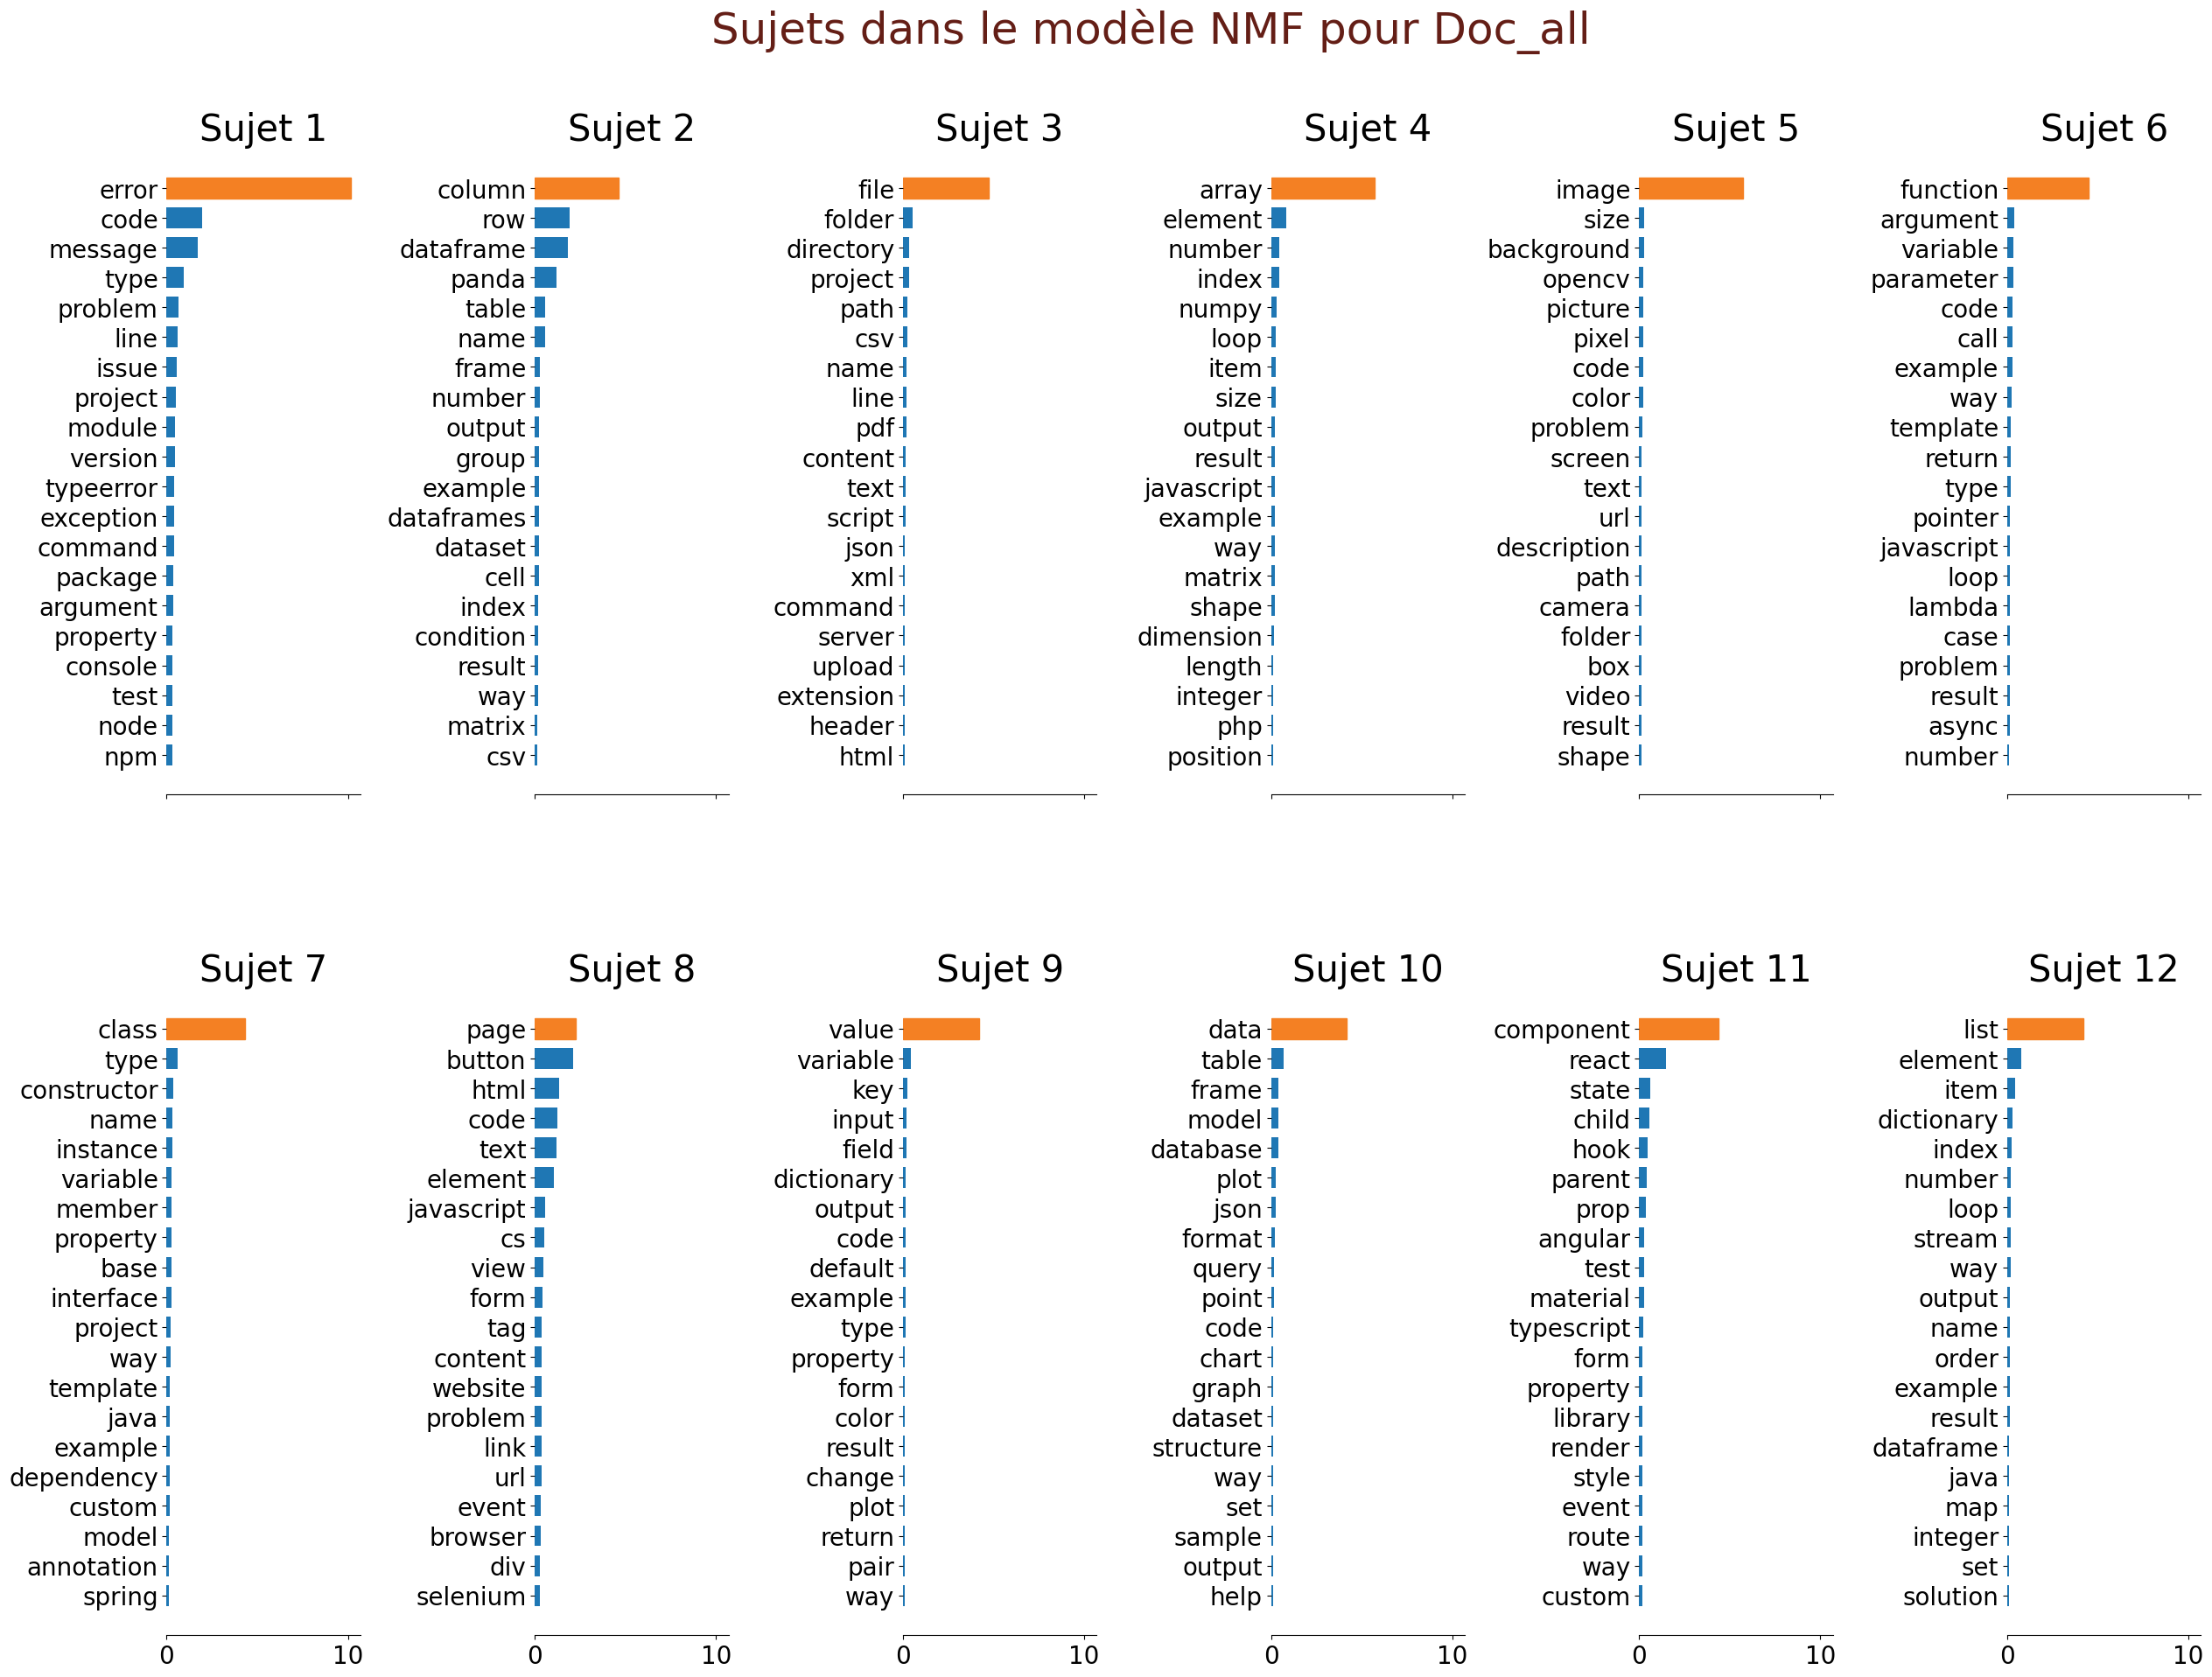

In [ ]:
import time
from sklearn.decomposition import NMF

# Définir le nombre de sujets à tester
best_nb_topics = 20
n_topics = best_nb_topics

print("-"*50)
print("Start NMF fitting on Doc_all ...")
print("-" * 50)
start_time = time.time()
# Initialisation de NMF
full_nmf = NMF(n_components=n_topics,
               init='nndsvd',
               random_state=8)

# Ajuster NMF sur le vecteur X_tfidf
full_nmf.fit(X_tfidf)

exec_time = time.time() - start_time
print("End of training :")
print("Execution time : {:.2f}s".format(exec_time))
print("-" * 50)

# Afficher les 12 premiers sujets
ff_feature_names = vectorizer.get_feature_names_out()
plot_top_words(full_nmf, ff_feature_names, 20, 12,
               'Sujets dans le modèle NMF pour Doc_all')

La modélisation avec NMF nous offre des catégories aussi compréhensibles que celles générées par l'algorithme LDA. Cependant, les thèmes générés restent très généraux et ne permettent pas une catégorisation cohérente pour notre problème d'auto-tagging.

### Régression logistique avec OneVsRestClassifier

En utilisant la première méthode d'extraction de texte (TF_IDF)

In [ ]:
import time
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier

# Initialiser la régression logistique avec OneVsRest
parametres_logit = {
"estimator__C": [100, 10, 1.0, 0.1],
"estimator__penalty": ["l1", "l2"],
"estimator__dual": [False],
"estimator__solver": ["liblinear"]
}

classificateur_logit = LogisticRegression()
# ExtraTreeclassifier
one_vs_rest_logit = OneVsRestClassifier(classificateur_logit)

grid_search_logit = GridSearchCV(
one_vs_rest_logit,
param_grid=parametres_logit,
n_jobs=-1,
cv=5,
scoring="f1_weighted",
return_train_score=True,
refit=True
)

grid_search_logit.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [100, 10, 1.0, 0.1],
                         'estimator__dual': [False],
                         'estimator__penalty': ['l1', 'l2'],
                         'estimator__solver': ['liblinear']},
             return_train_score=True, scoring='f1_weighted')

In [ ]:
logit_cv_results = pd.DataFrame.from_dict(grid_search_logit.cv_results_)
print("-"*50)
print("Best params for Logistic Regression")
print("-" * 50)
logit_best_params = grid_search_logit.best_params_
print(logit_best_params)

--------------------------------------------------
Best params for Logistic Regression
--------------------------------------------------
{'estimator__C': 10, 'estimator__dual': False, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}


In [ ]:
logit_cv_results[logit_cv_results["params"]==logit_best_params]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__dual,param_estimator__penalty,param_estimator__solver,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,3.826955,0.768342,0.03082,0.009275,10,False,l1,liblinear,"{'estimator__C': 10, 'estimator__dual': False,...",0.606632,...,0.605414,0.003425,1,0.66373,0.662938,0.662489,0.665713,0.663167,0.663607,0.001126


Maintenant, nous pouvons effectuer des prédictions à l'aide du modèle de régression logistique sur le jeu test

In [ ]:
# Prediction
y_test_predicted_labels_tfidf = grid_search_logit.predict(X_test)

# transformation inverse
y_test_pred_inversed = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_tfidf)
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_test)

print("-"*50)
print("Affichage des 5 premières étiquettes prédites par rapport aux étiquettes réelles")
print("-" * 50)
print("Pred:", y_test_pred_inversed)
print("True:", y_test_inversed)

--------------------------------------------------
Affichage des 5 premières étiquettes prédites par rapport aux étiquettes réelles
--------------------------------------------------
Pred: [('c#',), ('r',), (), ('python',), ('python',), ('swift',), ('c++',), ('java',), ('python', 'r'), ('php',), ('c++',), ('javascript',), (), ('android',), (), (), ('javascript', 'node.js'), (), ('angular',), ('java',), (), ('pandas', 'python'), ('c++',), ('php',), (), ('reactjs',), ('java',), ('python',), (), (), ('python',), (), (), ('python',), ('angular',), ('c++',), ('python',), ('java',), (), ('javascript',), (), ('java',), ('pandas', 'python'), ('javascript',), ('android',), (), ('reactjs',), (), (), ('php',), ('c#',), ('c#',), ('java',), ('python',), ('python',), ('c#',), ('c#',), ('python',), (), ('javascript', 'reactjs'), ('javascript', 'reactjs'), ('python',), ('pandas', 'python'), (), ('c++',), ('python',), (), ('html',), ('python',), ('c#',), ('python',), (), ('c++',), (), (), ('python',), 

In [ ]:
df_metrics_compare = metrics_score("Logit avec TfIDF",
                                   df=df_metrics_compare,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_tfidf)
df_metrics_compare

,LDA,Logit avec TfIDF
Précision,0.227755,0.445512
F1,0.404856,0.666402
Jaccard,0.132403,0.473702
Rappel,0.308085,0.532097
Précision,0.258446,0.774092


En utilisant la deuxième méthode d'extraction de texte

*   `List item`
*   List item

(Word2Vec)

In [ ]:
import time
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier

# Initialiser la régression logistique avec OneVsRest
parametres_logit_w2v = {
"estimator__C": [10],
"estimator__penalty": ["l1"],
"estimator__dual": [False],
"estimator__solver": ["liblinear"]
}

classificateur_logit = LogisticRegression()
one_vs_rest_logit = OneVsRestClassifier(classificateur_logit)

grid_search_logit = GridSearchCV(
one_vs_rest_logit,
param_grid=parametres_logit_w2v,
n_jobs=-1,
cv=5,
scoring="f1_weighted",
return_train_score=True,
refit=True
)

grid_search_logit.fit(X_train_w2v, y_train_w2v)

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [10], 'estimator__dual': [False],
                         'estimator__penalty': ['l1'],
                         'estimator__solver': ['liblinear']},
             return_train_score=True, scoring='f1_weighted')

In [ ]:
logit_cv_results_w2v = pd.DataFrame.from_dict(grid_search_logit.cv_results_)
print("-"*50)
print("Best params for Logistic Regression")
print("-" * 50)
logit_best_params_w2v = grid_search_logit.best_params_
print(logit_best_params_w2v)

--------------------------------------------------
Best params for Logistic Regression
--------------------------------------------------
{'estimator__C': 10, 'estimator__dual': False, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}


In [ ]:
logit_cv_results[logit_cv_results["params"]==logit_best_params_w2v]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__dual,param_estimator__penalty,param_estimator__solver,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,3.826955,0.768342,0.03082,0.009275,10,False,l1,liblinear,"{'estimator__C': 10, 'estimator__dual': False,...",0.606632,...,0.605414,0.003425,1,0.66373,0.662938,0.662489,0.665713,0.663167,0.663607,0.001126


In [ ]:
# Prediction
y_test_predicted_labels_w2v = grid_search_logit.predict(X_test_w2v)

# transformation inverse
y_test_pred_inversed = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_w2v)
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_test_w2v)

print("-"*50)
print("Affichage des 5 premières étiquettes prédites par rapport aux étiquettes réelles")
print("-" * 50)
print("Pred:", y_test_pred_inversed)
print("True:", y_test_inversed)

--------------------------------------------------
Affichage des 5 premières étiquettes prédites par rapport aux étiquettes réelles
--------------------------------------------------
Pred: [('c#',), (), (), ('python',), ('python',), (), ('c++',), (), ('python',), ('php',), ('c++',), ('html', 'javascript'), (), ('android',), (), ('python',), ('javascript', 'node.js'), ('python',), ('angular',), ('java',), ('python',), ('pandas', 'python'), ('c++',), ('php',), (), ('reactjs',), (), ('python',), (), ('javascript',), ('python',), (), (), ('python',), ('angular',), (), ('python',), ('java',), (), ('javascript',), (), ('java',), ('pandas', 'python', 'python-3.x'), (), (), (), ('reactjs',), (), (), ('php',), (), (), ('java',), ('python',), ('node.js',), ('c#',), ('c#',), ('python',), (), ('javascript', 'reactjs'), ('reactjs',), ('python',), ('pandas', 'python'), ('python',), ('c#', 'c++'), ('python',), (), ('html',), (), ('c#',), (), (), ('c++',), (), ('html',), ('python',), ('pandas', 'pytho

In [ ]:
df_metrics_compare = metrics_score("Logit avec w2v",
                                   df=df_metrics_compare,
                                   y_true = y_test_w2v,
                                   y_pred = y_test_predicted_labels_w2v)
df_metrics_compare

,LDA,Logit avec TfIDF,Logit avec w2v
Précision,0.227755,0.445512,0.372187
F1,0.404856,0.666402,0.610890
Jaccard,0.132403,0.473702,0.404590
Rappel,0.308085,0.532097,0.459787
Précision,0.258446,0.774092,0.744115


En utilisant SBERT

In [ ]:

# Initialiser la régression logistique avec OneVsRest
parametres_logit_sbert = {
"estimator__C": [10],
"estimator__penalty": ["l1"],
"estimator__dual": [False],
"estimator__solver": ["liblinear"]
}

classificateur_logit = LogisticRegression()
one_vs_rest_logit = OneVsRestClassifier(classificateur_logit)

grid_search_logit = GridSearchCV(
one_vs_rest_logit,
param_grid=parametres_logit_sbert,
n_jobs=-1,
cv=5,
scoring="f1_weighted",
return_train_score=True,
refit=True
)

grid_search_logit.fit(X_train_sbert, y_train_sbert)

logit_cv_results_sbert = pd.DataFrame.from_dict(grid_search_logit.cv_results_)
print("-"*50)
print("Best params for Logistic Regression")
print("-" * 50)
logit_best_params_sbert = grid_search_logit.best_params_
print(logit_best_params_sbert)

logit_cv_results[logit_cv_results["params"]==logit_best_params_sbert]


# Prediction
y_test_predicted_labels_sbert = grid_search_logit.predict(X_test_sbert)

# transformation inverse
y_test_pred_inversed = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_sbert)
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_test_sbert)

print("-"*50)
print("Affichage des 5 premières étiquettes prédites par rapport aux étiquettes réelles")
print("-" * 50)
print("Pred:", y_test_pred_inversed)
print("True:", y_test_inversed)

df_metrics_compare = metrics_score("Logit avec SBERT",
                                   df=df_metrics_compare,
                                   y_true = y_test_sbert,
                                   y_pred = y_test_predicted_labels_sbert)
df_metrics_compare




--------------------------------------------------
Best params for Logistic Regression
--------------------------------------------------
{'estimator__C': 10, 'estimator__dual': False, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}
--------------------------------------------------
Affichage des 5 premières étiquettes prédites par rapport aux étiquettes réelles
--------------------------------------------------
Pred: [('c#',), ('r',), ('swift',), ('python',), ('python',), ('android',), ('c++',), ('java',), ('python',), ('php',), ('swift',), ('javascript',), ('angular',), ('android',), ('javascript', 'reactjs'), ('python',), ('javascript', 'node.js'), (), ('angular',), ('java',), (), ('pandas', 'python'), ('c++',), ('php',), ('c#',), ('reactjs',), ('node.js',), ('python',), ('android',), ('angular',), ('python',), ('r',), ('c++',), ('python',), ('angular',), (), ('python',), ('java',), ('c#',), ('angular', 'html'), ('java',), ('java',), ('pandas', 'python'), ('html', 'jav

,LDA,Logit avec TfIDF,Logit avec w2v,Logit avec SBERT
Précision,0.227755,0.445512,0.372187,0.623135
F1,0.404856,0.666402,0.610890,0.800884
Jaccard,0.132403,0.473702,0.404590,0.654391
Rappel,0.308085,0.532097,0.459787,0.732687
Précision,0.258446,0.774092,0.744115,0.828381


In [ ]:
Question = 'Python problem :  How to convert '

In [ ]:
pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.5 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=f25357ea7020f813b03b12ebcec6ed96b9ba2828d68d76cfdd344dcbfc70a376
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

# Extraction des représentations vectorielles pour les phrases
Question_sbert = model.encode([Question])
## X.tolist()[0]
###convert_to_tensor=True)
#X_sbert = model.encode(X, convert_to_tensor=True)

print("Forme de X pour SBERT : {}".format(Question_sbert.shape))

Forme de X pour SBERT : (1, 384)


In [ ]:

# Initialiser la régression logistique avec OneVsRest
parametres_logit_sbert = {
"estimator__C": [10],
"estimator__penalty": ["l1"],
"estimator__dual": [False],
"estimator__solver": ["liblinear"]
}

classificateur_logit = LogisticRegression()
one_vs_rest_logit = OneVsRestClassifier(classificateur_logit)

grid_search_logit = GridSearchCV(
one_vs_rest_logit,
param_grid=parametres_logit_sbert,
n_jobs=-1,
cv=5,
scoring="f1_weighted",
return_train_score=True,
refit=True
)

grid_search_logit.fit(X_train_sbert, y_train_sbert)

logit_cv_results_sbert = pd.DataFrame.from_dict(grid_search_logit.cv_results_)
print("-"*50)
print("Best params for Logistic Regression")
print("-" * 50)
logit_best_params_sbert = grid_search_logit.best_params_
print(logit_best_params_sbert)

logit_cv_results[logit_cv_results["params"]==logit_best_params_sbert]


# Prediction
y_test_predicted_labels_sbert = grid_search_logit.predict(X_test_sbert)

# transformation inverse
y_test_pred_inversed = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_sbert)
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_test_sbert)

print("-"*50)
print("Affichage des 5 premières étiquettes prédites par rapport aux étiquettes réelles")
print("-" * 50)
print("Pred:", y_test_pred_inversed)
print("True:", y_test_inversed)

df_metrics_compare = metrics_score("Logit avec SBERT",
                                   df=df_metrics_compare,
                                   y_true = y_test_sbert,
                                   y_pred = y_test_predicted_labels_sbert)
df_metrics_compare




En utilisant USE

In [ ]:
# Initialiser la régression logistique avec OneVsRest
parametres_logit_use = {
"estimator__C": [10],
"estimator__penalty": ["l1"],
"estimator__dual": [False],
"estimator__solver": ["liblinear"]
}

classificateur_logit = LogisticRegression()
one_vs_rest_logit = OneVsRestClassifier(classificateur_logit)

grid_search_logit = GridSearchCV(
one_vs_rest_logit,
param_grid=parametres_logit_use,
n_jobs=-1,
cv=5,
scoring="f1_weighted",
return_train_score=True,
refit=True
)

grid_search_logit.fit(X_train_use, y_train_use)

logit_cv_results_use = pd.DataFrame.from_dict(grid_search_logit.cv_results_)
print("-"*50)
print("Best params for Logistic Regression")
print("-" * 50)
logit_best_params_use = grid_search_logit.best_params_
print(logit_best_params_use)

logit_cv_results[logit_cv_results["params"]==logit_best_params_use]


# Prediction
y_test_predicted_labels_use = grid_search_logit.predict(X_test_use)

# transformation inverse
y_test_pred_inversed = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_use)
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_test_use)

print("-"*50)
print("Affichage des 5 premières étiquettes prédites par rapport aux étiquettes réelles")
print("-" * 50)
print("Pred:", y_test_pred_inversed)
print("True:", y_test_inversed)

df_metrics_compare = metrics_score("Logit avec USE",
                                   df=df_metrics_compare,
                                   y_true = y_test_use,
                                   y_pred = y_test_predicted_labels_use)
df_metrics_compare

--------------------------------------------------
Best params for Logistic Regression
--------------------------------------------------
{'estimator__C': 10, 'estimator__dual': False, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}
--------------------------------------------------
Affichage des 5 premières étiquettes prédites par rapport aux étiquettes réelles
--------------------------------------------------
Pred: [(), ('r',), ('swift',), ('python',), (), ('c#',), ('c++',), ('java',), ('python',), ('php',), (), ('html', 'javascript'), (), ('android', 'java'), ('reactjs',), ('python',), ('javascript', 'node.js'), ('python',), ('angular',), ('java',), ('java',), ('pandas', 'python'), ('c++',), ('php',), ('c#',), ('javascript', 'reactjs'), ('node.js',), ('python', 'r'), ('android',), ('angular',), ('python',), ('r',), ('c++',), ('python', 'python-3.x'), ('angular',), ('java',), ('python',), ('java',), ('android', 'c#'), ('javascript',), ('java',), ('java',), ('pandas', '

,LDA,Logit avec TfIDF,Logit avec w2v,Logit avec SBERT,Logit avec USE
Précision,0.227755,0.445512,0.372187,0.623135,0.557016
F1,0.404856,0.666402,0.610890,0.800884,0.745806
Jaccard,0.132403,0.473702,0.404590,0.654391,0.576621
Rappel,0.308085,0.532097,0.459787,0.732687,0.662907
Précision,0.258446,0.774092,0.744115,0.828381,0.788789


Modélisation du meilleur modèle avec Random Forest

In [ ]:
import pickle

# Chemin du fichier pickle
fichier_pickle = "./data"

# Lecture du fichier pickle et récupération du vecteur X
with open(fichier_pickle, 'rb') as fichier_sbert:
    X_sbert = pickle.load(fichier_sbert)

# Affichage du vecteur X
print("Forme de X pour Doc_all : {}".format(X_sbert.shape))

Forme de X pour Doc_all : (26366, 15)


In [ ]:
# Création des ensembles d'entraînement et de test
X_train_sbert, X_test_sbert, y_train_sbert, y_test_sbert = train_test_split(X_sbert, y_binarized,
                                                    test_size=0.3, random_state=8)

print("Forme de X_train_sbert: {}".format(X_train_sbert.shape))
print("Forme de X_test_sbert : {}".format(X_test_sbert.shape))
print("Forme de y_train_sbert : {}".format(y_train_sbert.shape))
print("Forme de y_test_sbert : {}".format(y_test_sbert.shape))

Forme de X_train_sbert: (18456, 15)
Forme de X_test_sbert : (7910, 15)
Forme de y_train_sbert : (18456, 15)
Forme de y_test_sbert : (7910, 15)


In [ ]:
import time
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier

# Initialiser la régression logistique avec OneVsRest
parametres_logit_sbert = {
"estimator__C": [10],
"estimator__penalty": ["l1"],
"estimator__dual": [False],
"estimator__solver": ["liblinear"]
}

classificateur_logit = LogisticRegression()
one_vs_rest_logit = OneVsRestClassifier(classificateur_logit)

grid_search_logit = GridSearchCV(
one_vs_rest_logit,
param_grid=parametres_logit_sbert,
n_jobs=-1,
cv=5,
scoring="f1_weighted",
return_train_score=True,
refit=True
)

grid_search_logit.fit(X_train_sbert, y_train_sbert)


# Prediction
y_test_predicted_labels_sbert = grid_search_logit.predict(X_test_sbert)

# transformation inverse
y_test_pred_inversed = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_sbert)
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_test_sbert)

print("-"*50)
print("Affichage des 5 premières étiquettes prédites par rapport aux étiquettes réelles")
print("-" * 50)
print("Pred:", y_test_pred_inversed)
print("True:", y_test_inversed)





--------------------------------------------------
Affichage des 5 premières étiquettes prédites par rapport aux étiquettes réelles
--------------------------------------------------
Pred: [('c#',), ('r',), ('swift',), ('python',), ('python', 'python-3.x'), ('android',), ('c++',), ('java',), ('python', 'python-3.x'), ('php',), ('c++',), ('javascript',), ('angular',), ('android',), ('javascript', 'reactjs'), ('python',), ('javascript', 'node.js'), ('c++',), ('angular',), ('java',), ('python',), ('pandas', 'python'), ('c++',), ('javascript', 'node.js'), ('c#',), ('html', 'reactjs'), ('node.js',), ('python',), ('android', 'java', 'node.js'), ('angular',), ('python',), ('r',), ('c++',), ('python',), ('angular',), ('java',), ('python',), ('java',), ('c#',), ('angular', 'javascript'), ('java',), ('java',), ('pandas', 'python'), ('html', 'javascript'), ('android',), ('javascript',), ('reactjs',), ('java',), ('angular',), ('php',), ('c#',), ('c#',), ('java',), ('python', 'python-3.x'), ('pytho

In [ ]:
# Refit RandomForestClassifier best_params with full dataset
rfc_final_model = OneVsRestClassifier(RandomForestClassifier(**rfc_best_params_ok))
rfc_final_model.fit(X_train_sbert, y_train_sbert)

# Predict
y_test_predicted_labels_sbert_rfc = rfc_final_model.predict(X_test_sbert)

# Inverse transform
y_test_pred_inversed_rfc = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_sbert_rfc)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_rfc[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [(), ('python', 'r'), ('swift',), ('python',), ('python',)]
True: [('c#',), ('r',), ('swift',), ('python',), ('python', 'python-3.x')]


In [ ]:
df_metrics_compare = metrics_score("RandomForest",
                                   df=df_metrics_compare,
                                   y_true = y_test_sbert,
                                   y_pred = y_test_predicted_labels_sbert_rfc)
df_metrics_compare

,LDA,Logit avec TfIDF,Logit avec w2v,Logit avec SBERT,Logit avec USE,RandomForest
Précision,0.227755,0.445512,0.372187,0.623135,0.557016,0.492035
F1,0.404856,0.666402,0.610890,0.800884,0.745806,0.704715
Jaccard,0.132403,0.473702,0.404590,0.654391,0.576621,0.553655
Rappel,0.308085,0.532097,0.459787,0.732687,0.662907,0.653948
Précision,0.258446,0.774092,0.744115,0.828381,0.788789,0.766283
